In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [ ]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 MB 3.3 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 2.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 5.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 5.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.6/393.6 kB 4.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 5.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 4.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.0/601.0 kB 4.1 

idea: Reverse Engineering From Nutrition Labels
1. create equations --> system of equations. now need to optimize system of equations (can't solve because # ingredients doesn't
always equal # of equations (14 in this case, reason for 14 explained below). Can optimize with gradient descent.
2. perform gradient descent (create loss function, gradients, gradient loss function, update variable values)
3. randomize initial gradient descent inputs
4. choose solution with lowest loss.

In [2]:
#creating the overall dictionary: the one representing the nutrition label facts. I will copy this dictionary for any 
#ingredient I use.

overall_dict = {}

overall_dict["Fat"] = 0
overall_dict["Saturated fatty acids"] = 0
overall_dict["Fatty acids, total trans"] = 0
overall_dict["Cholesterol"] = 0
overall_dict["Sodium"] = 0
overall_dict["Carbohydrate"] = 0
overall_dict["Fiber"] = 0
overall_dict["Sugars"] = 0
overall_dict["Protein"] = 0
overall_dict["Calcium"] = 0
overall_dict["Iron"] = 0
overall_dict["Potassium"] = 0
overall_dict["Vitamin D"] = 0
overall_dict["Weight"] = 0

In [3]:
#nutritional information for tates cookies per 10 grams (each number was initially for  28 grams. So I had to multiply 
#each number by (10 * (1 / 28)) to get the information for 10 grams)

tates_dict = overall_dict.copy()
tates_dict["Fat"] = 7 * (10 * (1 / 28))
tates_dict["Saturated fatty acids"] = 4.5 * (10 * (1 / 28))
tates_dict["Fatty acids, total trans"] = 0 * (10 * (1 / 28))
tates_dict["Cholesterol"] = .025 * (10 * (1 / 28))
tates_dict["Sodium"] = .16 * (10 * (1 / 28))
tates_dict["Carbohydrate"] = 18 * (10 * (1 / 28))
tates_dict["Fiber"] = .8 * (10 * (1 / 28))
tates_dict["Sugars"] = 12 * (10 * (1 / 28))
tates_dict["Protein"] = 2 * (10 * (1 / 28))
tates_dict["Calcium"] = .0000001 * (10 * (1 / 28))
tates_dict["Iron"] = .0009 * (10 * (1 / 28))
tates_dict["Potassium"] = .01 * (10 * (1 / 28))
tates_dict["Vitamin D"] = .05 * (10 * (1 / 28))
tates_dict["Weight"] = 28 * (10 * (1 / 28))

In [4]:
tates_dict

{'Fat': 2.4999999999999996,
 'Saturated fatty acids': 1.607142857142857,
 'Fatty acids, total trans': 0.0,
 'Cholesterol': 0.008928571428571428,
 'Sodium': 0.057142857142857134,
 'Carbohydrate': 6.428571428571428,
 'Fiber': 0.2857142857142857,
 'Sugars': 4.285714285714285,
 'Protein': 0.7142857142857142,
 'Calcium': 3.5714285714285705e-08,
 'Iron': 0.00032142857142857136,
 'Potassium': 0.003571428571428571,
 'Vitamin D': 0.017857142857142856,
 'Weight': 9.999999999999998}

In [5]:
# function to transform the website information to dictionaries (with the keys of overall_dict). takes
# into account varying weight units (g/mg/mcg)

#examples used to test this function

file1 = "flour_unbleached_enriched_allpurpose_wheat.csv"
file2 = "butter_salted.csv"

ingredient_dict = overall_dict.copy()

def reader(file,ingredient_dict,desired_serving):
    with open(file, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        for i,row in enumerate(csvreader):
            if len(row) > 0 and row[0] in ingredient_dict:
                if row[2] == "mg":
                    ingredient_dict[row[0]] = (float(row[1]) / 1000) * desired_serving
                elif row[2] == "mcg":
                    ingredient_dict[row[0]] = (float(row[1]) / 1000000) * desired_serving
                else: #grams
                    ingredient_dict[row[0]] = (float(row[1])) * desired_serving
            if i == 4:
                index = row.index("g")
                ingredient_dict["Weight"] = float(row[index-1]) * desired_serving
    return ingredient_dict

In [6]:
reader(file2,ingredient_dict,2)

{'Fat': 16.222,
 'Saturated fatty acids': 10.274,
 'Fatty acids, total trans': 0.656,
 'Cholesterol': 0.043,
 'Sodium': 0.1286,
 'Carbohydrate': 0.02,
 'Fiber': 0.0,
 'Sugars': 0.02,
 'Protein': 0.18,
 'Calcium': 0.0048,
 'Iron': 0.0,
 'Potassium': 0.0048,
 'Vitamin D': 0.0,
 'Weight': 20.0}

In [7]:
#the various ingredients in Tate's. Transforming the online nutrritional information of each ingredient into individual dictionaries.

desired_serving = 1

semi_sweet_chocolate_file = "semisweet_chocolate_chips_by_raleys.csv"
semi_sweet_chocolate_dict = overall_dict.copy()
reader(semi_sweet_chocolate_file,semi_sweet_chocolate_dict,desired_serving)

unbleached_flour_file = "flour_unbleached_enriched_allpurpose_wheat.csv"
unbleached_flour_dict = overall_dict.copy()
reader(unbleached_flour_file,unbleached_flour_dict,desired_serving)

salted_butter_file = "butter_salted.csv"
salted_butter_dict = overall_dict.copy()
reader(salted_butter_file,salted_butter_dict,desired_serving)

cane_sugar_file = "granulated_pure_cane_sugar.csv"
cane_sugar_dict = overall_dict.copy()
reader(cane_sugar_file,cane_sugar_dict,desired_serving)

brown_cane_sugar_file = "brown_sugar_cane_by_frusecha.csv"
brown_cane_sugar_dict = overall_dict.copy()
reader(brown_cane_sugar_file,brown_cane_sugar_dict,desired_serving)

eggs_file = "egg_fresh_raw_whole.csv"
eggs_dict = overall_dict.copy()
reader(eggs_file,eggs_dict,desired_serving)

baking_soda_file = "leavening_agents_baking_soda.csv"
baking_soda_dict = overall_dict.copy()
reader(baking_soda_file,baking_soda_dict,desired_serving)

salt_file = "salt_table.csv"
salt_dict = overall_dict.copy()
reader(salt_file,salt_dict,desired_serving)

natural_vanilla_flavor_file = "vanilla_flavoring_syrup_by_r_torre__coinc.csv"
natural_vanilla_flavor_dict = overall_dict.copy()
reader(natural_vanilla_flavor_file,natural_vanilla_flavor_dict,desired_serving)

dictionary_list = [semi_sweet_chocolate_dict,unbleached_flour_dict,salted_butter_dict,cane_sugar_dict,brown_cane_sugar_dict,eggs_dict,baking_soda_dict,salt_dict,natural_vanilla_flavor_dict]
key_list = ["Fat","Saturated fatty acids","Fatty acids, total trans","Cholesterol","Sodium","Carbohydrate","Fiber","Sugars","Protein","Calcium","Iron","Potassium","Vitamin D","Weight"]

In [8]:
semi_sweet_chocolate_dict

{'Fat': 2.667,
 'Saturated fatty acids': 1.667,
 'Fatty acids, total trans': 0.0,
 'Cholesterol': 0.0,
 'Sodium': 0.0,
 'Carbohydrate': 6.67,
 'Fiber': 0.67,
 'Sugars': 5.33,
 'Protein': 0.67,
 'Calcium': 0.0,
 'Iron': 0.00027,
 'Potassium': 0.0,
 'Vitamin D': 0,
 'Weight': 10.0}

In [9]:
unbleached_flour_dict

{'Fat': 0.148,
 'Saturated fatty acids': 0,
 'Fatty acids, total trans': 0,
 'Cholesterol': 0,
 'Sodium': 0.0004,
 'Carbohydrate': 7.32,
 'Fiber': 0,
 'Sugars': 0,
 'Protein': 1.31,
 'Calcium': 0.0021000000000000003,
 'Iron': 0.00054,
 'Potassium': 0.0135,
 'Vitamin D': 0,
 'Weight': 10.0}

In [11]:
#creates a list of whatever inputted number (with a length of dictionary_list (number of variables))

def building_x_list(number,dictionary_list):
    x_list = []
    for variable in range(0, len(dictionary_list)):
        x_list.append(number)
    return x_list

x_list = building_x_list(1,dictionary_list)

#equations function (using Tate's cookies as an example): using the nutrition label (in this case, tates_dict), we're
#given the amount of macro and micronutrients in a serving of Tate's cookies. I changed these values to have the 
#dictionary output the amount of each macro/micronutrient in grams and for a serving of 10g of Tate's cookies.
#We're also given the ingredients in the cookies (bottom of nutrition label) and this is represented by dictionary_list.
#Each ingredient gets its own dictionary list, as I imported the micro/macronutrient information for each individual
#ingredient. Each ingredient dictionary reports the micro/macro information for each ingredient in grams and for a 
#serving of 10g. So now, with this information, we can build a system of equations with each equation corresponding to
#each micro/macronutrient (so each key value in the dictionaries). Each equation has variables x0,x1,...,x13 (14 variables)
#with xn representing the amount of the nth indexed ingredient in the dictionary_list (so x0 is the amount of semi-sweet 
#chocolate, x1 is the amount of flour, etc.). Each equation has all 14 variables, their respective coefficients, and what
#the equation equals. So for the first equation (which corresponds to the fat values), each variable's coefficient is the amount of 
#fat in that variable's corresponding ingredient. So if equation one looked like a0x0 + a1x1 + ... + a13x13 = C1:
#x0 is the amount of chocolate in 10g of Tate's cookies, a0 is the amount of fat in 10g of chocolate, x1 is the amount of flour
#in 10g of Tate's cookies, a1 is the amount of fat in 10g of flour, etc, and C1 is the amount of fat in 10g of Tate's cookies. equation one
#is for fat, equation two is for saturated fat, etc.

#so now for the equations function, I bring each Cn to the left side of the equation (so a0x0 + a1x1 + ... + a13x13 = C1
# goes to a0x0 + a1x1 + ... + a13x13 - C1, so instead of an equation I now have an expression. The equation function
#evaluates each expression. The function outputs a list with the value of each evaluated expression in order of key_list. 
# So this means the fat equation has index 0, saturated fat has index 1, etc. in the outputted list. Ideally, each expression should 
#evaluate to 0.

def equations(dictionary_list,x_list,desired_dict):
    list_of_equations = []
    for key in key_list:
        equation = 0
        for i,dictionary in enumerate(dictionary_list):
            equation = equation + (dictionary[key] * (x_list[i]))
        #subtracting the constant that the equation equals (a0x0 + a1x1 + ... + a13x13 = C1 -->  a0x0 + a1x1 + ... + a13x13 - C1)
        list_of_equations.append(equation-(desired_dict[key]*desired_serving))
    return list_of_equations


#gradients function: because each equation has variables with the highest degrees of one, the gradients with respect to each variable
#for each equation is just the coefficient of that variable. As stated above, this coefficient is just the respective value in 
#that variable (ingredient)'s key for that specific micro/macronutrient (which corresponds to equation number)
#basically, I'm saying that for the fat equation, the equation is a0x0 + a1x1 + ... + a13x13 = C. The
#derivative of the equation with respect to x0 is just a0. The gradients function would output a list for this first equation,
#with each index filled with the partial derivative of the equation with respect to the variable that has the same index of the list.
#So if the first equation is a0x0 + a1x1 + ... + a13x13 = C, the first list would be [a0,a1,...,a13].
#The function therefore outputs multiple lists (14), with each list being a list of the coefficients 
#corresponding to a macro/micronutrient (first list --> fat, second list --> saturated fat, etc., so the order of these lists is the 
#order of key_list. Stated again but maybe more simply: The first list is a list of partial derivatives of the first equation, and the 
#list is in order of partial derivatives of x0,...,x13. The second list is a list of partial derivatives of the second equation, etc. 
#The returned list is a list of all these lists.

def gradients(dictionary_list,x_list):
    list_of_gradients_of_equations = []
    for key in key_list:
        gradient = []
        for dictionary in dictionary_list:
            gradient.append(dictionary[key])
        list_of_gradients_of_equations.append(gradient)
    return list_of_gradients_of_equations

In [12]:
#these are the parameters that I'm implementing. Each ingredient value must be greater than 0 and because the nutrition
#label gives a list of ingredients in descending order, x0 > x1, x1> x2, etc. 

#the parameters function returns values if any of the variables violate the parameters. The function returns a list of 15 lists.
#The first 14 lists look at the parameters relating to the ingredients in descending order. The last list
#looks at the parameter of being greater than 0.

#For the first 14 lists, I had to choose how to "punish" the variables. If x0 < x1 < x2, do I "punish" all three variables
#looking at x0 < x1, x1 < x2, and x0 < x2? Or do I just look at the neighboring variables, so only having the violations be
#x0< x1 and x1<x2. It made more sense for me to do the latter, so for each neighboring violation, both variables are equally "punished."
#So, for the first list, every number should be 0 except for the first and second variables (0th and 1st index of the list) if 
#the x0 < x1. This is because the first list only looks at the first two variables. Then the second list looks at the second and third
#variables. etc.


def parameters(x_list,penalty_constant,dictionary_list):
    list_of_parameters = []
    list_of_parameters_over_0 = []
    for i in range(0,len(x_list)-1):
        parameter_for_over_0 = penalty_constant * ((max(0,(-1 * x_list[i]))) ** 2)
        list_of_parameters_over_0.append(parameter_for_over_0)
        parameter_for_inequality_individual_variable_list = building_x_list(0,dictionary_list)
        parameter_for_inequalities = penalty_constant * ((max(0, x_list[i+1] - x_list[i])) ** 2)
        parameter_for_inequality_individual_variable_list[i] = parameter_for_inequality_individual_variable_list[i] + (parameter_for_inequalities / 2)
        parameter_for_inequality_individual_variable_list[i+1] = parameter_for_inequality_individual_variable_list[i+1]+ (parameter_for_inequalities / 2)
        list_of_parameters.append(parameter_for_inequality_individual_variable_list)

    #the last variable. because my above loop goes from 0 to the n-1 variable. 
    list_of_parameters_over_0.append(10 * (max(0,-x_list[-1]) ** 2))
    list_of_parameters.append(list_of_parameters_over_0)

    return list_of_parameters

In [13]:
#this is the gradient function for the parameters. I'm just taking the partial derivatives of the parameter expressions
#I have above (in the parameters function). The function outputs a list containing 15 lists. Each list corresponds
#to the list of the same index in the parameters function (so the first list, or 0th index, is the partial derivatives 
#of the first list (or 0th index) outputted from the parameters function). Because each of the first 14 list has 0 entries
#except for (possibly-if they violate the parameter) two indices, the gradients list outputted that corresponds to that list
#also has 0 entries for everything but those two indices.



def gradients_of_parameters(x_list,penalty_constant,dictionary_list):
    list_of_gradients_of_parameters = []
    list_gradient_over_0 = building_x_list(0,dictionary_list)
    for i in range(0,len(x_list)-1):
        list_gradient_over_0[i] = (2 * penalty_constant) * max(0, -x_list[i])
        penalty_gradients_inequalities = building_x_list(0,dictionary_list)
        penalty_gradients_inequalities[i] = penalty_gradients_inequalities[i] + ((-2 * penalty_constant) * max(0, x_list[i+1] - x_list[i]))
        penalty_gradients_inequalities[i+1] = (2 * penalty_constant) * max(0, x_list[i+1] - x_list[i])
        list_of_gradients_of_parameters.append(penalty_gradients_inequalities)
    list_gradient_over_0[-1] = (-2 * penalty_constant) * max(0, -x_list[-1])

    #this is where gradient for over 0 goes. so this is the last list
    list_of_gradients_of_parameters.append(list_gradient_over_0)
    
    return list_of_gradients_of_parameters

In [14]:
#to normalize the gradients because initially, the gradients were growing too fast.
#normalizing the gradients makes the input of a penalty constant much less significant.

def normalize_gradients(gradients):
    norm = np.linalg.norm(gradients)
    if norm > 0:
        return [g / norm for g in gradients]
    return gradients

#loss function: calculates the loss, looking at to what extent the inputted variables violate the equation expressions (how far
#from 0 does the expression evaluate to) and the parameters.

def loss_function(dictionary_list,x_list,penalty_constant,desired_dict):
    list_of_equations = equations(dictionary_list,x_list,desired_dict)
    list_of_parameters = parameters(x_list,penalty_constant,dictionary_list)
    loss = 0
    for equation in list_of_equations:
        loss = loss + (equation ** 2)
    for parameter in list_of_parameters:
        loss = loss + (np.sum(parameter))
    return loss


#gradient loss function: first, the function adds the gradient lists from the equations and parameters to get a
#list of 29 (14 + 15) lists. In each of these lists, the index of the gradient determines what variable it corresponds to
#(as said above, for example, gradient in index of one in any of these lists corresponds to the semi-sweet chocolate variable, x0).
#The function outputs one list, and each index in this list is: the sum of each equation multiplied by that index in all 29 the 
#gradient lists. Then, the final list is normalized.

def gradient_loss_function(dictionary_list,x_list,penalty_constant,desired_dict):
    list_of_equations = equations(dictionary_list,x_list,desired_dict)
    list_of_gradients_of_equations = gradients(dictionary_list,x_list)
    list_of_gradients_of_parameters = gradients_of_parameters(x_list,penalty_constant,dictionary_list)
    list_of_gradients_loss = building_x_list(0,dictionary_list)
    list_of_gradients = list_of_gradients_of_equations + list_of_gradients_of_parameters
    
    for equation in list_of_equations:
        for gradient_list_in_question in list_of_gradients:
            for j in range(0,len(gradient_list_in_question)):
                list_of_gradients_loss[j] = list_of_gradients_loss[j] + (2 * gradient_list_in_question[j] * equation)
    list_of_gradients_loss = normalize_gradients(list_of_gradients_loss)
    return list_of_gradients_loss

In [15]:
learning_rate = 0.00001

#this is the function that updates the inputted variables list (and updates it max_iters amount of times (unless the outputted
#loss is within .00006 of the one before it, then the function breaks)). First, the gradients_loss_function and loss_function are
# evaluated. Then for each index in the inputted variables list, the function alters the existing list, subtracting (the learning
#rate * the gradient_loss_list value at that index) from the current value. Then the loss function is calculated again.

#if graphing == True, then the loss with respect to the number of iterations is graphed.

#if light == True, that means that there are "light" ingredients that I want to restrain. This is because ingredients like 
#vanilla extract or baking soda barely have macro/micronutrients, so its a lot harder to account for them in the system of equations.
#But, to ensure that they don't go "crazy", I limit their values.


def updating_x_values(dictionary_list,x_listy,penalty_constant,desired_dict,max_iters,serving,light,graphing):
    
    if graphing == True:
        fig, ax = plt.subplots()
    
    for i in range(0,max_iters):
        
        gradient_loss_list = gradient_loss_function(dictionary_list,x_listy,penalty_constant,desired_dict)
        loss_before = loss_function(dictionary_list,x_listy,penalty_constant,desired_dict)
        
        for j in range(0,len(x_listy)):
            x_listy[j] = x_listy[j] - (learning_rate * gradient_loss_list[j])
            
            
            if light == True:
                x_listy[j] = max(x_listy[j],0)
                x_listy[-1] = min(x_listy[-1],.004)
                x_listy[-2] = min(x_listy[-2],.004)
                x_listy[-3] = min(x_listy[-3],.004)
                
        loss_after = loss_function(dictionary_list,x_listy,penalty_constant,desired_dict)
        
        if graphing == True:
            plt.plot(i,loss_after,"om")
            
        if loss_before - loss_after < .00006:
            if graphing == True:
                print("breaking at: " + str(i))
            break
        
    if graphing == True:
        plt.ylabel("loss")
        plt.xlabel("iterations")
        plt.show()
        print("Solution:", x_listy)
        print("Loss at solution:", loss_after)
        x_for_one_serving = []
        for x in x_listy:
            x_for_one_serving.append(x * serving)
        print("for one serving (in g):", x_for_one_serving)
        print("weight:", np.sum(x_listy) * 10)
        
    return loss_after

breaking at: 5907


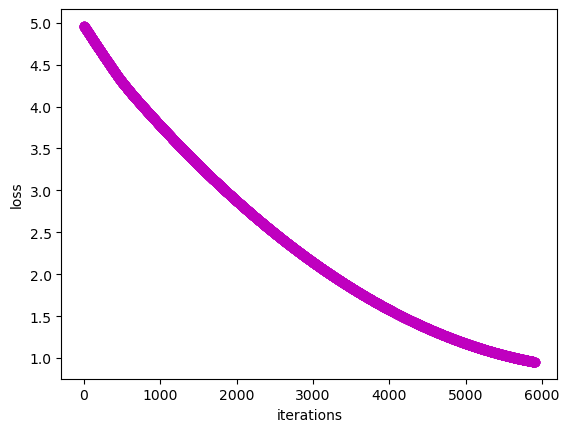

Solution: [0.3138886806722169, 0.2222669130727289, 0.20756622324169835, 0.12169715941012081, 0.12472616104166677, 0.08800879014263148, 2.0346668731665764e-06, 2.21727407134651e-06, 1.5978429385474032e-06]
Loss at solution: 0.9545768336721946
for one serving (in g): [389.84974139489344, 276.0555060363293, 257.79724926618934, 151.14787198737005, 154.90989201375012, 109.3069173571483, 0.002527056256472888, 0.002753854396612366, 0.001984520929675875]
weight: 10.781597773649462


0.9545768336721946

In [46]:
updating_x_values(dictionary_list,[.34,.24,.23,.15,.15,.1,.001,.001,.001],1,tates_dict,10000,1242,True,True)

In [ ]:
#what if we did this but just with the heavy ingredients (so exluding vanilla, baking soda, etc.). 

In [123]:
#slightly adjusting the weight of the tate's cookies serving

heavy_tates_dict = tates_dict.copy()
heavy_tates_dict["Weight"] += -.01

#altering the dictionary list to exclude the "light" ingredients (so excluding vanilla, salt, and baking soda)
heavy_dictionary_list = [semi_sweet_chocolate_dict,unbleached_flour_dict,salted_butter_dict,cane_sugar_dict,brown_cane_sugar_dict,eggs_dict]

breaking at: 5553


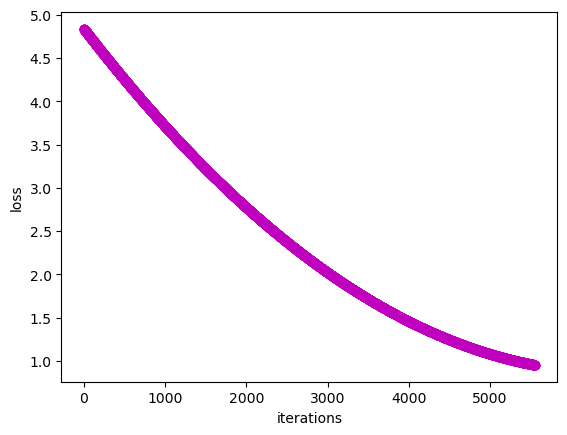

Solution: [0.3138914625298704, 0.22226880232707666, 0.20756861329992468, 0.12170302584377322, 0.12472600258064327, 0.08801006766670016]
Loss at solution: 0.9545949509032461
for one serving (in g): [389.853196462099, 276.0578524902292, 257.8002177185065, 151.15515809796634, 154.90969520515895, 109.3085040420416]
weight: 10.781679742479884


0.9545949509032461

In [33]:
updating_x_values(heavy_dictionary_list,[.34,.24,.23,.15,.15,.1],2,tates_dict,10000,1242,False,True)

In [ ]:
#the outputs are very similar. So, I decided to continue including the light ingredients and just put light == True.

In [15]:
#now looking at the tates gluten-free cookies.
#the nutritional information is very similar to the non-gluten-free cookies I looked at above, except flour is replaced with 
#rice flour, xantham gum is added, and very minor changes are made to the micro/macronutrient values.

tates_dict_gluten_free = overall_dict.copy()
tates_dict_gluten_free["Fat"] = 7 * (10 * (1 / 28))
tates_dict_gluten_free["Saturated fatty acids"] = 4.5 * (10 * (1 / 28))
tates_dict_gluten_free["Fatty acids, total trans"] = 0 * (10 * (1 / 28))
tates_dict_gluten_free["Cholesterol"] = .020 * (10 * (1 / 28))
tates_dict_gluten_free["Sodium"] = .135 * (10 * (1 / 28))
tates_dict_gluten_free["Carbohydrate"] = 19 * (10 * (1 / 28))
tates_dict_gluten_free["Fiber"] = .8 * (10 * (1 / 28))
tates_dict_gluten_free["Sugars"] = 12 * (10 * (1 / 28))
tates_dict_gluten_free["Protein"] = 1 * (10 * (1 / 28))
tates_dict_gluten_free["Calcium"] = .01 * (10 * (1 / 28))
tates_dict_gluten_free["Iron"] = .0007 * (10 * (1 / 28))
tates_dict_gluten_free["Potassium"] = .04 * (10 * (1 / 28))
tates_dict_gluten_free["Vitamin D"] = .0 * (10 * (1 / 28))
tates_dict_gluten_free["Weight"] = 28 * (10 * (1 / 28))

rice_flour_file = "rice_flour_unenriched_white.csv"
rice_flour_dict = overall_dict.copy()
reader(rice_flour_file,rice_flour_dict,desired_serving)

xanthan_gum_file = "xanthan_gum_by_namaste.csv"
xanthan_gum_dict = overall_dict.copy()
reader(xanthan_gum_file,xanthan_gum_dict,desired_serving)

dictionary_list_gluten_free = [semi_sweet_chocolate_dict,rice_flour_dict,salted_butter_dict,cane_sugar_dict,brown_cane_sugar_dict,eggs_dict,natural_vanilla_flavor_dict,baking_soda_dict,salt_dict,xanthan_gum_dict]
dictionary_list_gluten_free_heavy = [semi_sweet_chocolate_dict,rice_flour_dict,salted_butter_dict,cane_sugar_dict,brown_cane_sugar_dict,eggs_dict]

breaking at: 6523


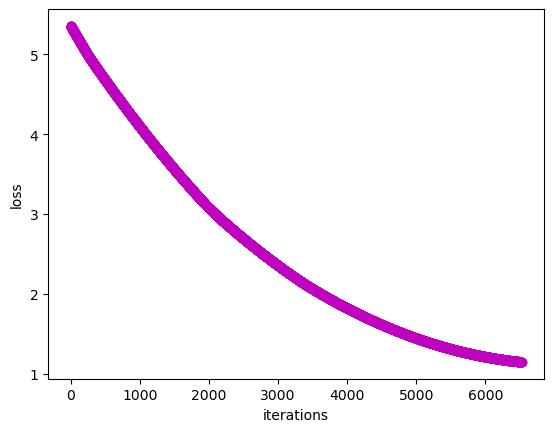

Solution: [0.3133751544740307, 0.22168235426372251, 0.20712502255225523, 0.12114355548448455, 0.12422608291414731, 0.08777296136920072, 1.4753865333053935e-06, 1.8787329042231958e-06, 2.047345347024014e-06, 3.8130636752509077e-06]
Loss at solution: 1.1495197666300132
for one serving (in g): [389.21194185674614, 275.32948399554334, 257.249278009901, 150.46029591172982, 154.28879497937098, 109.0140180205473, 0.0018324300743652988, 0.002333386267045209, 0.002542802921003825, 0.0047358250846616275]
weight: 10.753343455863009


1.1495197666300132

In [35]:
updating_x_values(dictionary_list_gluten_free,[.34,.24,.23,.15,.15,.1,.005,.005,.005,.001],2,tates_dict_gluten_free,10000,1242,True,True)

In [ ]:
#The outputs + loss heeavily depends on the initial input. So what if we randomize the inputs?

In [16]:
#function returns a list of sorted (from increasing to decreasing) random values to act as the x_list input. 
#These random values are floats between 0 and 1 and all sum to 1.

def generate_random_floats(dictionary_list):
    random_values = np.random.uniform(0, 1, len(dictionary_list))
    
    # Normalize so their sum equals 1
    normalized_values = random_values / np.sum(random_values)
    
    lst = normalized_values.tolist()
    lsty = sorted(lst,reverse=True)
    return lsty

In [17]:
#doing the updating_x_values function on random x_list inputs. The amount of random x_list inputs tried is the 
#random_iterations variable. The function conducts the updating_x_values function for a random input, and gets the
#loss from the solution list. Then the function does it for random_iterations number of random x_lists. the function
#outputs the random list whose solution generates the lowest loss and the corresponding solution.

#the function also graphs the lowest loss so far with the number of random x_list iterations.

def finding_the_best_from_randomized(dictionary_list,penalty_constant,desired_dict,random_iterations,gradient_iterations,serving,light,graphing):
    loss_list = []
    lowest_loss = 5
    lowest_loss_x_values = []
    fig, ax = plt.subplots()
    
    for i in range(0,random_iterations):
        x_list = generate_random_floats(dictionary_list)
        loss = updating_x_values(dictionary_list,x_list,penalty_constant,desired_dict,gradient_iterations,serving,light,graphing)
        if loss < lowest_loss:
            lowest_loss = loss
            lowest_loss_x_values = x_list
        plt.plot(i,lowest_loss,"or")
    plt.xlabel("number of random x_lists looked at")
    plt.ylabel("lowest loss so far")
    plt.show()
    serving_list = []
    for number in lowest_loss_x_values:
        serving_list.append(number * serving) 

    print("lowest loss: ", lowest_loss)
    print("solution: ", lowest_loss_x_values)
    print("solution in terms of serving size (in g): ", serving_list)
    return

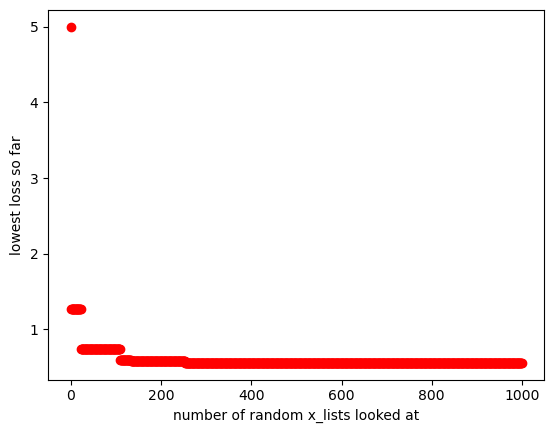

lowest loss:  0.5581997375599612
solution:  [0.24627622810682848, 0.21396452740536595, 0.1649723876293002, 0.159927457165604, 0.1501683548478646, 0.029943960917721675, 0.004, 0.004, 0.003957718091468754]
solution in terms of serving size (in g):  [305.87507530868095, 265.74394303746453, 204.89570543559083, 198.62990179968017, 186.50909672104783, 37.19039945981032, 4.968, 4.968, 4.9154858696041925]


In [60]:
finding_the_best_from_randomized(dictionary_list,1,tates_dict,1000,10000,1242,True,False)

In [ ]:
# next steps... try other food products other than Tate's. Prioritize foods with less add-ins like dyes, extracts, etc.

In [18]:
# larabar:
desired_serving = 1

lara_bar_dict = overall_dict.copy()
lara_bar_dict["Fat"] = 9 * (10 * (1 / 45))
lara_bar_dict["Saturated fatty acids"] = 1.5 * (10 * (1 / 45))
lara_bar_dict["Fatty acids, total trans"] = 0 * (10 * (1 / 45))
lara_bar_dict["Cholesterol"] = 0 * (10 * (1 / 45))
lara_bar_dict["Sodium"] = .005 * (10 * (1 / 45))
lara_bar_dict["Carbohydrate"] = 27 * (10 * (1 / 45))
lara_bar_dict["Fiber"] = 3 * (10 * (1 / 45))
lara_bar_dict["Sugars"] = 17 * (10 * (1 / 45))
lara_bar_dict["Protein"] = 4 * (10 * (1 / 45))
lara_bar_dict["Calcium"] = 0 * (10 * (1 / 45))
lara_bar_dict["Iron"] = .0017 * (10 * (1 / 45))
lara_bar_dict["Potassium"] = .3 * (10 * (1 / 45))
lara_bar_dict["Vitamin D"] = .0 * (10 * (1 / 45))
lara_bar_dict["Weight"] = 45 * (10 * (1 / 45))

cashew_file = "cashews.csv"
cashew_dict = overall_dict.copy()
reader(cashew_file,cashew_dict,desired_serving)

dates_file = "date.csv"
dates_dict = overall_dict.copy()
reader(dates_file,dates_dict,desired_serving)

apples_file = "apples_with_skin_raw.csv"
apples_dict = overall_dict.copy()
reader(apples_file,apples_dict,desired_serving)

blueberries_file = "blueberries_raw.csv"
blueberries_dict = overall_dict.copy()
reader(blueberries_file,blueberries_dict,desired_serving)

lara_bar_dictionary_list = [cashew_dict,dates_dict,apples_dict,blueberries_dict]

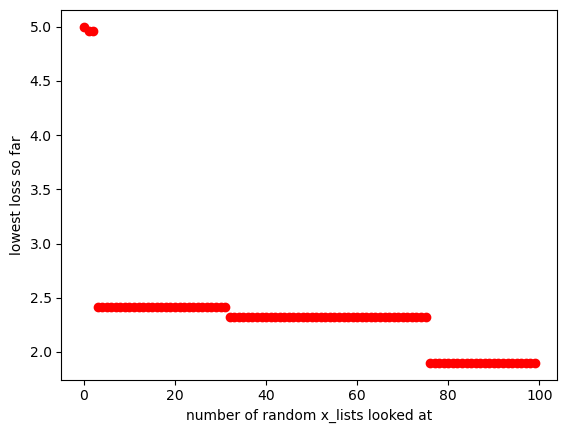

lowest loss:  1.9000041541749055
solution:  [0.5020783529702147, 0.44548989711592946, 0.05103878994842143, 0.03525427718285719]
solution in terms of serving size (in g):  [22.593525883659662, 20.047045370216825, 2.2967455476789644, 1.5864424732285736]


In [62]:
finding_the_best_from_randomized(lara_bar_dictionary_list,1,lara_bar_dict,100,10000,45,False,False)

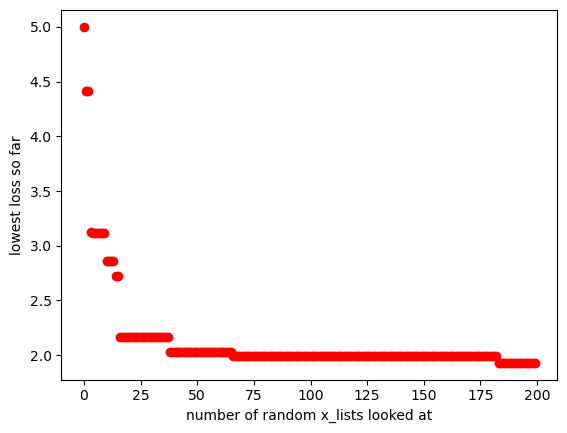

lowest loss:  1.9310066176955538
solution:  [0.5022050083920407, 0.4439225690998785, 0.04554506518373698, 0.04272524323564672]
solution in terms of serving size (in g):  [22.599225377641833, 19.97651560949453, 2.049527933268164, 1.9226359456041024]


In [68]:
finding_the_best_from_randomized(lara_bar_dictionary_list,1,lara_bar_dict,200,10000,45,False,False)

In [22]:
#trying something: looking at the bon appetite copycat recipe vs. guess (only heavy).

bon_appetite_list_goal = [340,240,227,150,165,100]
for i in range(0,len(bon_appetite_list_goal)):
    bon_appetite_list_goal[i] = bon_appetite_list_goal[i] / 1242
    
actual_list = [0.3138914625298704, 0.22226880232707666, 0.20756861329992468, 0.12170302584377322, 0.12472600258064327, 0.08801006766670016]
error_squared = 0
error_subtracted = 0

for i in range(0,len(bon_appetite_list_goal)):
    error_subtracted = error_subtracted + abs((bon_appetite_list_goal[i] - actual_list[i]))
    error_squared = error_squared + ((bon_appetite_list_goal[i] - actual_list[i]) ** 2)

print("error from abs of difference: ", error_subtracted)
print("error from squaring the difference", error_squared)

error from abs of difference:  0.11051951175980974
error from squaring the difference 0.00319206219241987


In [25]:
#looking at the loss of the "actual values": the bon appetite copy cat recipe

loss_function(heavy_dictionary_list,bon_appetite_list_goal,1,heavy_tates_dict)

#the copy cat recipe has a loss of 1.1.

0.535614252286891

breaking at: 2163


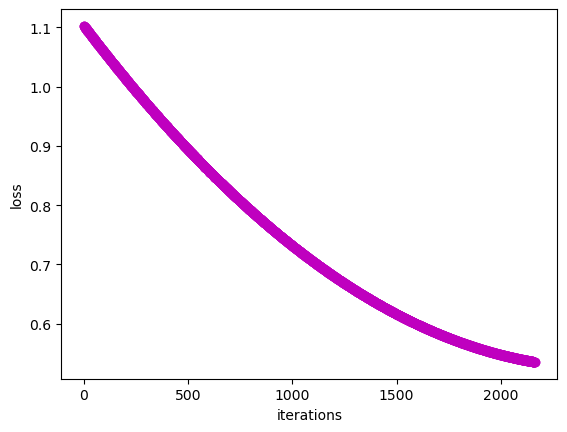

Solution: [0.28392848189913633, 0.20014790193734128, 0.19151293187625484, 0.1317961867745166, 0.142707655442569, 0.0851886801303907]
Loss at solution: 0.535614252286891
for one serving (in g): [352.6391745187273, 248.58369420617785, 237.8590613903085, 163.6908639739496, 177.2429080596707, 105.80434072194525]
weight: 10.352818380602088


0.535614252286891

In [24]:
updating_x_values(heavy_dictionary_list,bon_appetite_list_goal,1,heavy_tates_dict,10000,1242,False,True)

Conclusion:
- because manufacturing companies don't release their exact ingredient makeup, it's hard to measure how "right" I was.
So, I looked at my loss function as the indicator, with a loss close to 0 signifying "rightness."
- ingredients like vanilla extract or baking soda were hard to determine due to the lack of nutritional information they
have (Ex. both have 0g carbohydrates, 0g fat, 0g protein, etc.) and therefore, my model was not the best at predicting these
values (unless I clipped them). Using gradient descent to optimize these equations works most optimally for products
with little add-ins (dyes, extracts, etc. that have little micro/macronutrient information).
- maybe I could take this project future, expanding to pharmaceutical labels and breaking down those labels.
- the poster link (summarizing background,methods,results,limitations,conclusion,and references)

In [40]:
from IPython.display import IFrame
IFrame("reverse_engineering_food_products final_poster.pdf", width=900, height=650)


next steps: comparing with built-inn python optimizers:


In [35]:
#1: tf.train.*Optimizer
import tensorflow as tf

In [124]:
def initialize_variables_tf(n):
    # Random positive values
    initial_values = tf.random.uniform(shape=(n,), minval=0.0, maxval=1.0)
    
    # Sort in descending order
    initial_values = tf.sort(initial_values, direction='DESCENDING')
    
    # Normalize to sum to 1
    initial_values = initial_values / tf.reduce_sum(initial_values)
    
    return tf.Variable(initial_values, trainable=True)

In [128]:
def loss_tf(predicted):
    
    #descending_penalty = tf.reduce_sum(tf.nn.relu(predicted[:-1] - predicted[1:]))
    
    #return tf.reduce_mean(tf.square(predicted)) + (10 * descending_penalty)
    return tf.reduce_mean(tf.square(predicted))

In [142]:
def running_tf(dictionary_list,target_dict):

    n = len(dictionary_list)
    variables_tf = initialize_variables_tf(n)    

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Training loop
    for epoch in range(200):  # Number of epochs
        with tf.GradientTape() as tape:
        # Step 1: Evaluate the equations
             predictions1 = equations(dictionary_list,variables_tf,target_dict)
             predictions = tf.convert_to_tensor(predictions1)
        # Step 2: Compute the loss
             loss = loss_tf(predictions)

    # Step 3: Compute gradients
        gradients = tape.gradient(loss, [variables_tf])

    # Step 4: Apply gradients to update variables
        optimizer.apply_gradients(zip(gradients, [variables_tf]))

    # Apply constraints
    # 1. Ensure all variables are positive
        variables_tf.assign(tf.maximum(variables_tf, 0.0))
 
        variables_tf.assign(variables_tf / tf.reduce_sum(variables_tf))
    
    # 2. Ensure variables are in descending order
    #variables_tf.assign(tf.sort(variables_tf, direction='DESCENDING'))

    # Optional: Print progress
        if epoch % 20 == 0:  # Print every 20 epochs
            print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}, Variables: {variables_tf.numpy()}")

    x_for_one_serving = []
    for x in variables_tf.numpy():
        x_for_one_serving.append(x * 1242)
    
    return x_for_one_serving

In [144]:
running_tf(dictionary_list,tates_dict)

Epoch 0, Loss: 0.2114, Variables: [0.1956229  0.17097732 0.1622007  0.16078396 0.13624685 0.06784991
 0.04971647 0.04766131 0.00894052]
Epoch 20, Loss: 0.0399, Variables: [0.20919411 0.17068301 0.18591599 0.19103949 0.16299166 0.04880639
 0.01547973 0.01199108 0.00389853]
Epoch 40, Loss: 0.0290, Variables: [0.21137768 0.17946677 0.19512528 0.18983036 0.16291898 0.04520652
 0.00812882 0.00564212 0.00230345]
Epoch 60, Loss: 0.0258, Variables: [0.21195592 0.18440063 0.19764097 0.18882976 0.16258287 0.04347068
 0.00551956 0.00416707 0.0014325 ]
Epoch 80, Loss: 0.0246, Variables: [0.21217118 0.1867747  0.1985657  0.18830618 0.16240856 0.04251555
 0.00441167 0.00393996 0.00090652]
Epoch 100, Loss: 0.0240, Variables: [0.21228524 0.18790801 0.1989894  0.18804513 0.162333   0.04197375
 0.00387269 0.00401463 0.00057813]
Epoch 120, Loss: 0.0237, Variables: [0.21236067 0.18847087 0.19920938 0.18790944 0.16229968 0.04166569
 0.00358141 0.00413242 0.00037044]
Epoch 140, Loss: 0.0235, Variables: [0.2

[263.9289864599705,
 234.82412722706795,
 247.72874602675438,
 233.1809987425804,
 201.5316528081894,
 51.306725330650806,
 3.980787211563438,
 5.436380943283439,
 0.08165743174322415]

In [ ]:
#2:

"""from sklearn.linear_model import SGDRegressor

 sgd=SGDRegressor(learning_rate='constant',eta0=0.01)

 batch_size=15 #specifying the batch size

 for i in range(100):

     indexes=random.sample(range(x_train.shape[0]),batch_size)

     sgd.partial_fit(x_train[indexes],y_train[indexes])

 sgd.predict()"""

In [ ]:
#3:
"""import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import torch.nn.functional as F

from collections import OrderedDict
from torch.autograd import Variable
from IPython.core.display import display, HTML"""

In [ ]:
#4: try the git of medium article